In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

measurement_column = inspector.get_columns('Measurement')
for item in measurement_column:
    print(item['name'], item["type"])

station_column = inspector.get_columns('Station')
for item in station_column:
    print(item['name'], item["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

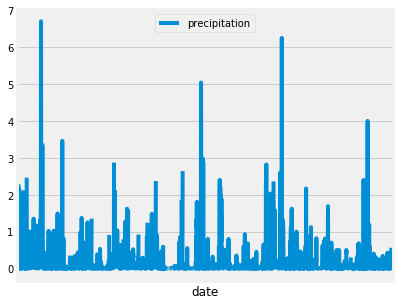

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
prior_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

query_data = session.query(Measurement.date, Measurement.prcp).\
filter(func.strftime(Measurement.date) >= prior_date).all()

precip = pd.DataFrame(query_data, columns = ['date', 'prcp'])
precip = precip.set_index('date', drop=True)

precip = precip.sort_values(by='date',ascending=True)

bar_chart = precip.plot(use_index = False, grid = True, figsize = (6,5), xticks = [])
bar_chart.legend(('precipitation',), loc = 'upper center')
bar_chart.set_xlabel("date")

plt.savefig('Images/precipitation.png')

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).count()
print(stations)

9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_max = session.query(Measurement.station, func.max(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').group_by(Measurement.station).all()

station_avg = session.query(Measurement.station, func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').group_by(Measurement.station).all()

station_min = session.query(Measurement.station, func.min(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').group_by(Measurement.station).all()

print(station_max)
print(station_avg)
print(station_min)

[('USC00519281', 85.0)]
[('USC00519281', 71.66378066378067)]
[('USC00519281', 54.0)]


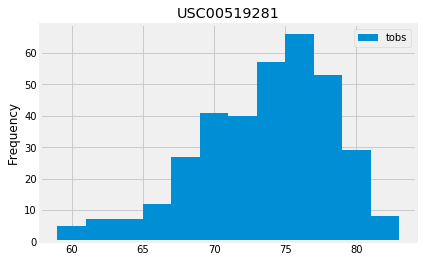

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

active_station = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(func.strftime(Measurement.date) >= prior_date).\
order_by(Measurement.date).all()


active_station_df = pd.DataFrame(active_station, columns = ['date', 'tobs'])

active_station_df.hist(bins=12)
plt.legend(('tobs',))
plt.title('USC00519281')
plt.ylabel('Frequency')
plt.show
plt.savefig('Images/station-histogram.png')

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

vacation_start = '2017-06-30'
vacation_end = '2017-07-04'

temp_range = (calc_temps(vacation_start, vacation_end))

print(temp_range)

[(74.0, 77.92592592592592, 87.0)]


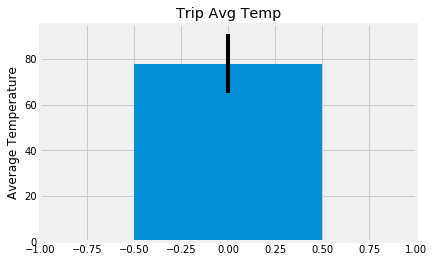

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

peaks = temp_range[0][2] - temp_range[0][0]

y = [temp_range[0][1]]
x = 0

fig, ax = plt.subplots()
ax.bar(x, y, width=1, yerr=peaks)
ax.set_xbound(lower=-1, upper=1)
ax.tick_params(axis='x')
ax.set_ylabel('Average Temperature')
ax.set_title("Trip Avg Temp")

plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_calculation = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
station_calculation = session.query(*rainfall_calculation).filter(Measurement.station == Station.station).\
        filter(Measurement.date >= vacation_start).\
        filter(Measurement.date <= vacation_end).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).statement

rainfall_data = pd.read_sql_query(station_calculation, session.bind)
rainfall_data.rename(columns = {'sum_1':'rainfall'}, inplace = True)
rainfall_data

,station,name,latitude,longitude,elevation,rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.20
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.47
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.31
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.20
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.12
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.09
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.00


## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date



In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
